In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

In [2]:
torch.manual_seed(1)

# Load data and create dataset

In [3]:
import glob

base_data_path = "./MelanomaDetectionLabeled/MelanomaDetectionLabeled/"

In [4]:
x_train = []
y_train = []

for img in glob.glob(f"{base_data_path}/labeled/*.jpg"):
    _x = read_image(img)
    _y = int(img.split(".")[1][-1])
    x_train.append(_x)
    y_train.append(_y)

In [5]:
x_test = []
y_test = []

for img in glob.glob(f"{base_data_path}/test/*.jpg"):
    _x = read_image(img)
    _y = int(img.split(".")[1][-1])
    x_test.append(_x)
    y_test.append(_y)

In [6]:
from torchvision.transforms import v2

class Melanoma(Dataset):
    def __init__(self, x, y):
        super(Melanoma, self).__init__()
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        transform = v2.Compose([v2.ToTensor()])

        x = transform(self.x[idx]).to(torch.float32)
        return x, self.y[idx]

In [7]:
train_data = Melanoma(x_train, y_train)
trainloader = DataLoader(train_data, shuffle=True, batch_size=64)

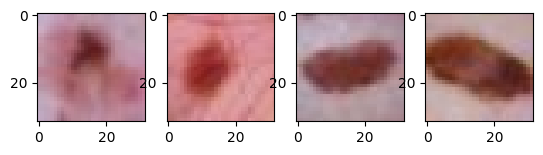

In [32]:
import matplotlib.pyplot as plt

samples = next(iter(trainloader))[0][:4, :, :, :].to(int)

fig, ax = plt.subplots(1, 4)

for i, img in enumerate(samples):
    ax[i].imshow(torch.moveaxis(img, 0, -1))

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, pooling):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(pooling)
        self.modules = [self.conv, self.relu, self.pool]

    def forward(self, x):
        for l in self.modules:
            x = l(x)
        return x

In [10]:
class LinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout):
        super(LinearBlock, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.modules = [self.linear, self.relu, self.dropout]

    def forward(self, x):
        for l in self.modules:
            x = l(x)
        return x

In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = ConvBlock(3, 32, 3, 2) # 32x30x30 --pool--> 32x15x15
        self.conv2 = ConvBlock(32, 64, 3, 2) # 64x13x13 --pool--> 64x7x7
        self.conv3 = ConvBlock(64, 16, 2, 2) # 16x6x6 --pool--> 16x2x2
        self.flatten = nn.Flatten()
        self.linear1 = LinearBlock((16*2*2), 100, 0.3)
        self.linear2 = LinearBlock(100, 64, 0.3)
        self.linear3 = LinearBlock(64, 16, 0.2)
        self.linear4 = nn.Linear(16, 1)
        self.sigmoid = torch.sigmoid
        self.modules = [
            self.conv1, self.conv2, self.conv3, self.flatten, self.linear1, self.linear2, self.linear3, self.linear4, self.sigmoid
        ]

    def forward(self, x):
        for l in self.modules:
            x = l(x)
        return x

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [22]:
model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0002)
loss_fn = nn.BCELoss()

In [24]:
import numpy as np

num_epochs = 100

for epoch in range(num_epochs):
    losses = []
    correct = 0
    samples = 0
    for x, y in trainloader:
        x = x.to(device)
        y = y.view(len(y), 1).to(torch.float32).to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        samples += len(y)
        correct += (pred.round() == y).sum()
    print(f"{epoch+1} - Loss: {np.mean(losses)} - Acc: {correct/samples} ")

1 - Loss: 0.5095296204090118 - Acc: 0.7299999594688416 
2 - Loss: 0.4854995161294937 - Acc: 0.7649999856948853 
3 - Loss: 0.4851443022489548 - Acc: 0.7649999856948853 
4 - Loss: 0.4387097507715225 - Acc: 0.73499995470047 
5 - Loss: 0.43408646434545517 - Acc: 0.7799999713897705 
6 - Loss: 0.45277610421180725 - Acc: 0.7699999809265137 
7 - Loss: 0.3711507134139538 - Acc: 0.7849999666213989 
8 - Loss: 0.4330637454986572 - Acc: 0.7699999809265137 
9 - Loss: 0.6233578622341156 - Acc: 0.7299999594688416 
10 - Loss: 0.48996593803167343 - Acc: 0.7549999952316284 
11 - Loss: 0.4519329071044922 - Acc: 0.7999999523162842 
12 - Loss: 0.5297395214438438 - Acc: 0.7450000047683716 
13 - Loss: 0.4341745600104332 - Acc: 0.7949999570846558 
14 - Loss: 0.4604657366871834 - Acc: 0.7699999809265137 
15 - Loss: 0.42432503402233124 - Acc: 0.7699999809265137 
16 - Loss: 0.4706873372197151 - Acc: 0.7799999713897705 
17 - Loss: 0.41289833188056946 - Acc: 0.8149999976158142 
18 - Loss: 0.41933953762054443 - Acc: